In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

# Analysis

In [3]:
PROJECT_ROOT = "./RESULTS/Review 2"

## Configuration

In [4]:
# Load corresponding simulations (hyper-parameter tuning + forecasting) for each country.
COUNTRIES = ["Yemen", "Syria", "Burkina Faso", "Nigeria", "Mali", "Cameroon"] 

In [5]:
for country in COUNTRIES:
    print(country)
    # Load forecasting results for each split.
    xls = pd.ExcelFile(f"{PROJECT_ROOT}/{country}/standard/out_test/forecast.xlsx")

    for i, split in enumerate(xls.sheet_names[1:]):
        forecast_split = pd.read_excel(xls, split, index_col = 0, header = [0, 1, 2])
        print(f"{split}: {forecast_split.index[0].date()} - {forecast_split.index[-1].date()}")

Yemen
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Syria
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Burkina Faso
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Nigeria
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Mali
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02
Cameroon
Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01

In [6]:
# Select what splits to consider for the current analysis.
SELECT_SPLITS = {"Yemen": [1, 2, 3, 4, 5], 
                 "Syria": [1, 2, 3, 4, 5], 
                 "Burkina Faso": [1, 2, 3, 4, 5], 
                 "Nigeria": [1, 2, 3, 4, 5], 
                 "Mali": [1, 2, 3, 4, 5], 
                 "Cameroon": [1, 2, 3, 4, 5]}

## Metrics

In [7]:
all_results = {}
for i, country in enumerate(COUNTRIES):
    selected_splits = ["Split {}".format(s) for s in SELECT_SPLITS[country]]
    # Values forecasting.
    values = {}
    xls = pd.ExcelFile(f"{PROJECT_ROOT}/{country}/standard/out_test/forecast.xlsx")
    for split in selected_splits:
        forecast_split = pd.read_excel(xls, split, index_col = 0, header = [1, 2]).reset_index(drop = True)
        values[split] = forecast_split
    values = pd.concat(values, axis = 1)
    values.index = np.arange(1, len(values)+1)
    # Load training shapes.
    training_shape = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/training_shapes.csv", header = [0, 1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    training_shape = training_shape[selected_splits] # Filter
    # Load mse losses (model and naive) based on prediction horizons.
    loss_h = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1])
    loss_h = loss_h.droplevel(level = 0, axis = 0)
    loss_h = loss_h[selected_splits] # Filter
    # Load r2 (model and naive) based on prediction horizons.
    r2_h = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])
    r2_h = r2_h.droplevel(level = 0, axis = 1)
    r2_h = r2_h[selected_splits] # Filter
    # Variance (constant for each prediction horizon).
    variance = values.xs("FCG", axis = 1, level = 2, drop_level = False)
    variance = variance.apply(np.var)
    variance = variance.unstack([0, 1]).reset_index(drop = True)
    variance.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["variance"]), variance.columns)), 
                                                 names = ["Split", "AdminStrata", "Type"])
    variance = variance.groupby(axis = 1, level = [0, 2]).mean() # Average across adminstratas.
    variance = variance.loc[variance.index.repeat(len(values))]
    variance.index = values.index
    # Difference between naive and actual values.
    difference_naive = values.drop("Forecast", axis = 1, level = 2).stack([0, 1])
    difference_naive["abs_diff_naive"] = np.abs(difference_naive["FCG"] - difference_naive["Naive"])
    difference_naive = difference_naive.drop(["FCG", "Naive"], axis = 1)
    difference_naive = difference_naive.unstack([1, 2]).groupby(axis = 1, level = [0, 1]).mean()
    difference_naive = difference_naive.reorder_levels([1, 0], axis = 1)
    
    # Concatenation.
    results = pd.concat([training_shape, loss_h, r2_h, variance, difference_naive], axis = 1)
    results = results.sort_index(axis = 1)
    
    # Select some prediction horizon for visualization.
    results = results.loc[[7, 14, 21, 28]]
        
    all_results[country] = results

In [8]:
all_results = pd.concat(all_results, axis = 1)
all_results.columns.names = ["Country", "Split", "Info"]
all_results

Country          Yemen                                            \
Split          Split 1                                             
Info    abs_diff_naive  mse_model  mse_naive  r2_model  r2_naive   
7             1.992526   6.829464   6.766452  0.948191  0.948669   
14            3.351301  12.408533  14.994235  0.904829  0.884997   
21            4.135824  20.405919  22.275783  0.867968  0.855869   
28            4.664415  24.572833  27.843013  0.843717  0.822918   

Country                                                                 ...  \
Split                                    Split 2                        ...   
Info    training points  variance abs_diff_naive  mse_model  mse_naive  ...   
7                 13900  4.210186       2.655326  10.626694  11.579975  ...   
14                13760  4.210186       4.388290  24.345664  26.280870  ...   
21                13620  4.210186       5.832588  38.099980  45.493989  ...   
28                13480  4.210186       6.991380  49.737796  71.187163  ...   

Country  Cameroon                                                       \
Split     Split 4                                   Split 5              
Info     r2_naive training points   variance abs_diff_naive  mse_model   
7        0.911010            7830  16.391857       2.568693  11.257303   
14       0.621494            7760  16.391857       2.924570  13.885210   
21       0.399068            7690  16.391857       4.343164  26.731853   
28      -0.240816            7620  16.391857       5.700584  34.224373   

Country                                                           
Split                                                             
Info     mse_naive  r2_model  r2_naive training points  variance  
7         9.640611  0.874892  0.892859            8140  7.586633  
14       12.110513  0.842454  0.862590            8070  7.586633  
21       25.039582  0.786999  0.800483            8000  7.586633  
28       52.607955  0.778342  0.659279            7930  7.586633  

[4 rows x 210 columns]

In [35]:
all_results.to_csv(f"{PROJECT_ROOT}/variance.csv")

array([<AxesSubplot:title={'center':'index'}, xlabel='[Country]'>,
       <AxesSubplot:title={'center':'value'}, xlabel='[Country]'>],
      dtype=object)

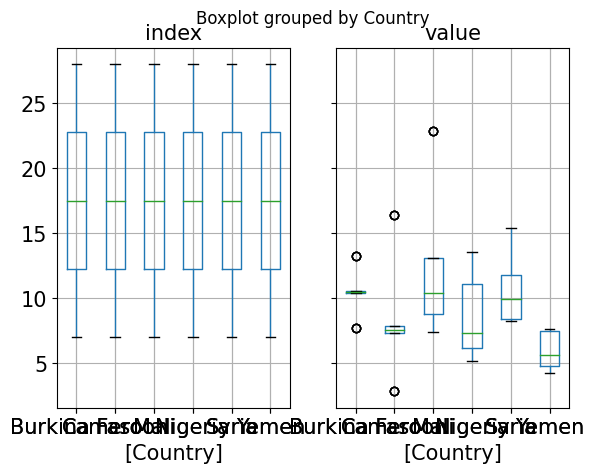

In [27]:
a = pd.melt(all_results, ignore_index=False).reset_index().groupby(["index", "Country", "Split", "Info"]).mean()
b = a.xs("variance", axis = 0, level = 3).reset_index()
b.boxplot(by=['Country'])